In [1]:
%matplotlib inline
import operator
import talib
import numpy as np
import pandas as pd
import time
from datetime import datetime, date, timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import seaborn
import matplotlib.pyplot as plt

from db import (db, prices, get_performance, 
                prepare_pair, get_prices_yahoo, months_generator)

pd.set_option('display.max_rows', 500) # default 30
pd.set_option('display.max_columns', 80) # default 20
pd.set_option('max_colwidth', 100) # default 40

def zscore_std(series, name="z-score"):
    return ((series - series.mean()) / np.std(series)).rename(name)

def zscore_std_np(a):
    b = (a - a.mean()) / np.std(a)
    b[np.isnan(b)] = 0
    return b

def get_diff(y):
    """
    Метод наименьших квадратов
    для поиска разницы между парами.
    """
    x = np.array([i for i in range(len(y))])
    arr = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(arr, y)[0]
    #print(m, c)
    return c

In [2]:
analyze_length = 370
# 2015
analyze_date = datetime(2016, 1, 1)
pair = ('CIT', 'STT')
#pair = ('ALNY', 'DATA')
#pair = ('DRE', 'O')

bad_pair = ('IBM', 'KGC')

symbol_list = list(pair) + list(bad_pair)
all_prices = prices(list(symbol_list), analyze_date, analyze_length)
symbol_test_prices = {s: np.array([x[5] for x in all_prices if x[0] == s]) for s in symbol_list}
symbol_dates = {s: np.array([x[1] for x in all_prices if x[0] == s]) for s in symbol_list}

# get all lengths
all_lengths = [len(p) for s, p in symbol_test_prices.items()]
length_limit = min(all_lengths)

pair

('CIT', 'STT')

Score=-6.0671; P-value=0.0000; Cointegrated=True; Crit[5%]=-2.8730 
Spread mean=1.40702; Spread median=1.56777; Percentile 80%=2.04092;


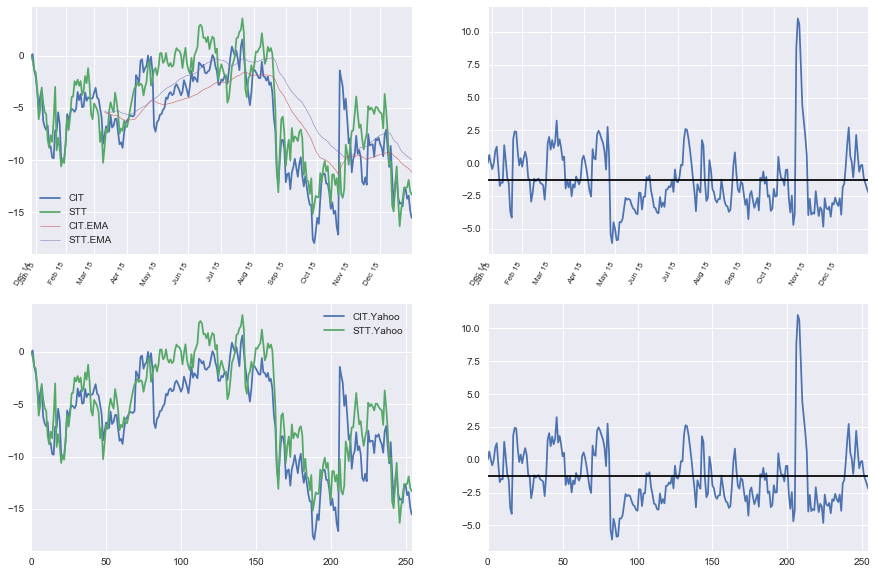

In [3]:
S1 = symbol_test_prices[pair[0]]
S2 = symbol_test_prices[pair[1]]

yprices = get_prices_yahoo([pair[0], pair[1]], dt_end=analyze_date)
Y1 = yprices[pair[0]].as_matrix()[-length_limit:]
Y2 = yprices[pair[1]].as_matrix()[-length_limit:]

# подготавливаем ряды
X, Y = prepare_pair(S1, S2, to_performance=True)
YX, YY = prepare_pair(Y1, Y2, to_performance=True)

period = 50
ema1 = talib.EMA(X, timeperiod=period)
ema2 = talib.EMA(Y, timeperiod=period)

# расчеты
diff = (ema1[period-1:] - ema2[period-1:])
diff_mean = abs(diff).mean()
diff_median = np.median(abs(diff))
diff_percentile = np.percentile(abs(diff), 80)

# prepare charts
X = pd.Series(X, name=pair[0])
Y = pd.Series(Y, name=pair[1])
YX = pd.Series(YX, name=pair[0] + '.Yahoo')
YY = pd.Series(YY, name=pair[1] + '.Yahoo')
X_ema = pd.Series(ema1, name=pair[0] + '.EMA')
Y_ema = pd.Series(ema2, name=pair[1] + '.EMA')

# xticks
dates = symbol_dates[pair[0]][-len(X):]
months = list(months_generator(dates))
xticks = [i for i in range(0, len(X)) if dates[i] in months]
xticklabels = [dt.strftime('%b %y') for dt in months]

# draw performance and MAs
fig, axs = plt.subplots(2,2, figsize=(15, 10))
pd.concat([X, Y], axis=1).plot(xticks=xticks, ax=axs[0][0]) # Performance
pd.concat([X_ema, Y_ema], axis=1).plot(ax=axs[0][0], linewidth=0.5) # SMA50
# xtick labels
axs[0][0].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# draw spread
diff_series = pd.Series(X - Y, name='-'.join(pair))
diff_series.plot(xticks=xticks, ax=axs[0][1])
axs[0][1].axhline(diff_series.mean(), color='black')
# xtick labels
axs[0][1].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# Yahoo.Finance for comparison
pd.concat([YX, YY], axis=1).plot(ax=axs[1][0]) # Performance
Ydiff_series = pd.Series(YX - YY, name='-'.join(pair))
Ydiff_series.plot(ax=axs[1][1])
axs[1][1].axhline(Ydiff_series.mean(), color='black')

result = adfuller(X-Y)
score, pvalue, crit = result[0], result[1], result[4]
print(
    'Score={0:.4f}; P-value={1:.4f}; Cointegrated={2}; Crit[5%]={3:.4f}'.format(score, pvalue, score < crit['5%'], crit['5%']),
    '\nSpread mean={0:.5f}; Spread median={1:.5f}; Percentile 80%={2:.5f};'.format(diff_mean, diff_median, diff_percentile)
)

(255,)

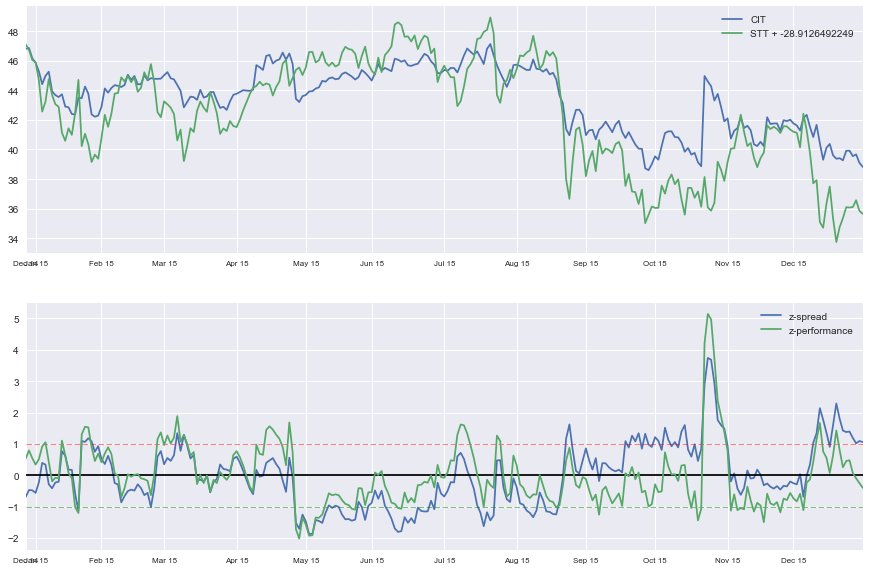

In [4]:
# Draw prices with z-score 
P1, P2 = prepare_pair(S1, S2, to_performance=False)

assets_diff = get_diff(P1 - P2)

coef_idx = -1 # 0/-1
ratio = S1[coef_idx]/S2[coef_idx]
P1 = pd.Series(P1, name=pair[0]) # приводим к одной цене по первому отношению
#P2 = pd.Series(P2, name=pair[1] + ' x ' + str(ratio))
P2 = pd.Series(P2, name=pair[1] + ' + ' + str(assets_diff))

# convert to same price
P2 = P2 + assets_diff

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
pd.concat([P1, P2], axis=1).plot(xticks=xticks, ax=axs[0]) # рисуем оба ряда

# xtick labels
axs[0].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

diff_series = P1 - P2
zscore_std(diff_series, name="z-spread").plot(xticks=xticks, ax=axs[1], legend=True)
axs[1].axhline(zscore_std(diff_series).mean(), color='black')
axs[1].axhline(1.0, color='red', linestyle='--', linewidth=0.5)
axs[1].axhline(-1.0, color='green', linestyle='--', linewidth=0.5)
# xtick labels
axs[1].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)
Perf1 = pd.Series(Perf1, name=pair[0])
Perf2 = pd.Series(Perf2, name=pair[1])
zscore_std(Perf1 - Perf2, name="z-performance").plot(xticks=xticks, ax=axs[1], legend=True)

# spread
#(P1 - P2).plot(xticks=xticks, ax=axs[2])
#(Perf1 - Perf2).plot(xticks=xticks, ax=axs[2])

# change background
fig.set_facecolor('white')

P1.shape

# OLS

const    5.834348
STT      0.527684
dtype: float64 0.797740047791


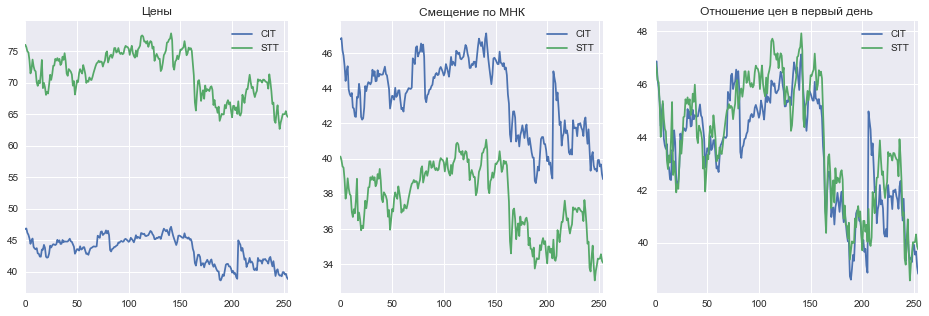

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
# change background
fig.set_facecolor('white')

# цены
axs[0].set_title('Цены')
P1 = pd.Series(S1, name=pair[0])
P2 = pd.Series(S2, name=pair[1])
P1.plot(legend=True, ax=axs[0])
P2.plot(legend=True, ax=axs[0])

# мнк
axs[1].set_title('Смещение по МНК')
Y = P1.copy()[:]
X = P2.copy()[:]

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.params, model.rsquared)

P1.plot(legend=True, ax=axs[1])
(P2 * model.params[1]).plot(legend=True, ax=axs[1])

# отношение цены первого дня
axs[2].set_title('Отношение цен в первый день')
coef = P1[0] / P2[0]
P1.plot(legend=True, ax=axs[2])
(P2 * coef).plot(legend=True, ax=axs[2])


('CIT', 'STT') Correlation: 0.866644955827


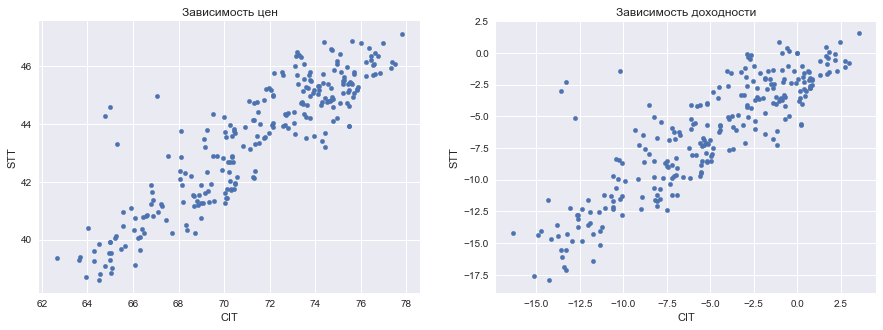

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# change background
fig.set_facecolor('white')

# left chart
axs[0].set_title('Зависимость цен')
price_xy = pd.DataFrame(S1, columns=[pair[1]], index=S2)
price_xy[pair[0]] = price_xy.index
price_xy.plot.scatter(x=pair[0], y=pair[1], ax=axs[0])

# right chart
axs[1].set_title('Зависимость доходности')
Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)
performance_xy = pd.DataFrame(Perf1, columns=[pair[1]], index=Perf2)
performance_xy[pair[0]] = performance_xy.index
performance_xy.plot.scatter(x=pair[0], y=pair[1], ax=axs[1])
#performance_xy

# correlation
print(pair, 'Correlation:', talib.CORREL(Perf1, Perf2, timeperiod=len(Perf1))[-1])

In [7]:
P1, P2 # цены
Y = P1.copy()[:]
X = P2.copy()[:]

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.params, model.rsquared)

model.summary()

const    5.834348
STT      0.527684
dtype: float64 0.797740047791


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CIT   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     997.9
Date:                Sat, 06 May 2017   Prob (F-statistic):           8.83e-90
Time:                        18:27:28   Log-Likelihood:                -355.62
No. Observations:                 255   AIC:                             715.2
Df Residuals:                     253   BIC:                             722.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.8343      1.193      4.892      0.000         3.486     8.183
STT            0.5277      0.017     31.589      0.000         0.495     0.561
==============================================================================
Omnibus:                       58.909   Durbin-Watson:                   0.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.900
Skew:                           1.094   Prob(JB):                     5.09e-30
Kurtosis:                       5.813   Cond. No.                     1.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Сравнение разных пар

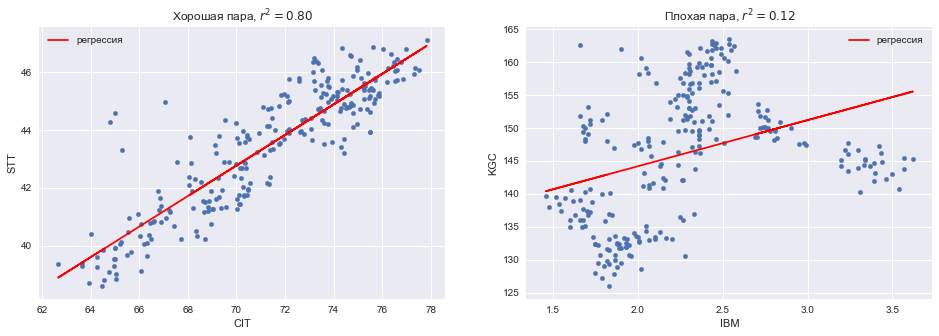

In [18]:
S3 = symbol_test_prices[bad_pair[0]]
S4 = symbol_test_prices[bad_pair[1]]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
# change background
fig.set_facecolor('white')

# left chart
axs[0].set_title('Хорошая пара, $r^2={0:.2f}$'.format(model.rsquared))
price_xy = pd.DataFrame(S1, columns=[pair[1]], index=S2)
price_xy[pair[0]] = price_xy.index
price_xy.plot.scatter(x=pair[0], y=pair[1], ax=axs[0])

a, b = model.params
axs[0].plot(S2, a + b*S2, color='red', label="регрессия")
legend = axs[0].legend() # add the legend

# simple example: draw regression
#fit = np.polyfit(S2, S1, deg=1)
#axs[0].plot(S2, fit[0] * S2 + fit[1], color='red')

# right chart
Y = pd.Series(S3)
X = pd.Series(S4)

X = sm.add_constant(X)
bad_model = sm.OLS(Y, X).fit()

axs[1].set_title('Плохая пара, $r^2={0:.2f}$'.format(bad_model.rsquared))
bad_pair = ('IBM', 'KGC')
S3 = symbol_test_prices[bad_pair[0]]
S4 = symbol_test_prices[bad_pair[1]]

bad_xy = pd.DataFrame(S3, columns=[bad_pair[1]], index=S4)
bad_xy[bad_pair[0]] = bad_xy.index
bad_xy.plot.scatter(x=bad_pair[0], y=bad_pair[1], ax=axs[1])

a, b = bad_model.params
axs[1].plot(S4, a + b*S4, color='red', label="регрессия")
legend = axs[1].legend() # add the legend